# Weather: Wind Speed – SARIMA on Normalized Differences of IHS-Transformed

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Analysis-and-Transformation" data-toc-modified-id="Analysis-and-Transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis and Transformation</a></span></li><li><span><a href="#Hyper-Parameters-Search" data-toc-modified-id="Hyper-Parameters-Search-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyper Parameters Search</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and Validation</a></span><ul class="toc-item"><li><span><a href="#Scores" data-toc-modified-id="Scores-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Scores</a></span></li><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li></ul></div>

## Initialization

In [1]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [2]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [3]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [4]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [5]:
import os
import sys
import time
import IPython.display
from pprint import pprint
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import timeseries as tss
from timeseries import plot_ts
from timeseries.analysis import acf, pacf, plot_hist, plot_acf, plot_pacf, plot_stats
from timeseries.transform import IHSTransformer, get_smoothed
from timeseries.forecast.utils import Results
from timeseries.forecast.utils import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from timeseries.forecast.scorings import get_comparison_scorings
from timeseries.forecast import average_scores
from timeseries.forecast.hyper_params import (
    make_grid,
    grid_search_hyper_params,
    print_hyper_scores,
    sorted_scores,
)
from timeseries.forecast.models import (
    SarimaModel,
    sarima_model_version,
    sarima_model_version_str,
)

from timeseries_data import WindSpeedData

<IPython.core.display.Javascript object>

In [6]:
import nb_black

from notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [7]:
scorings = get_comparison_scorings()

ts_data = WindSpeedData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Analysis and Transformation

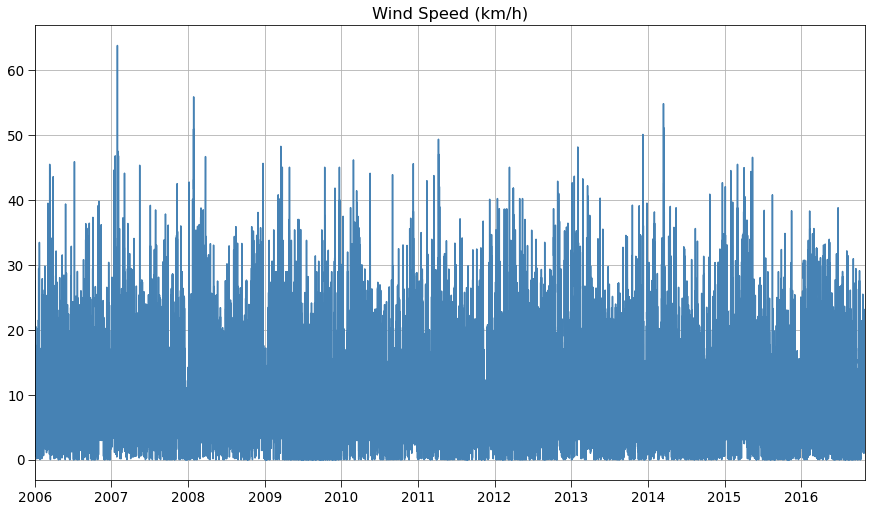

<IPython.core.display.Javascript object>

In [8]:
plot_ts(ts)

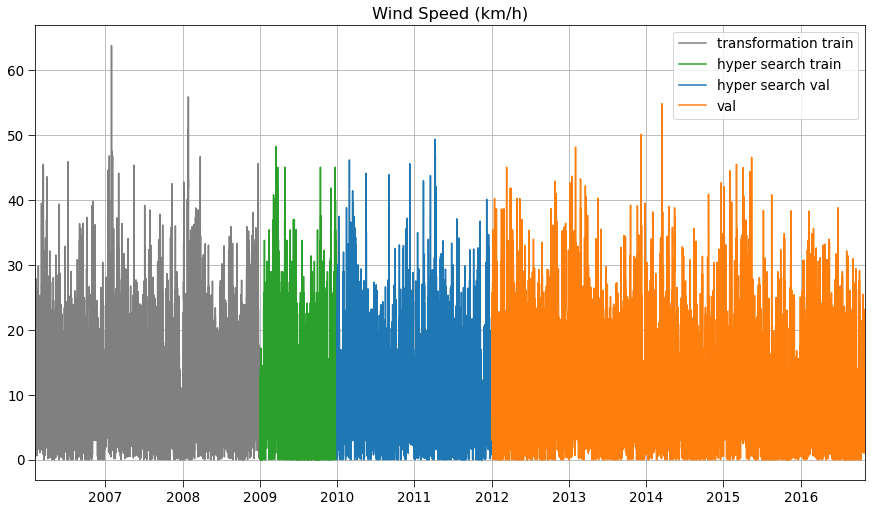

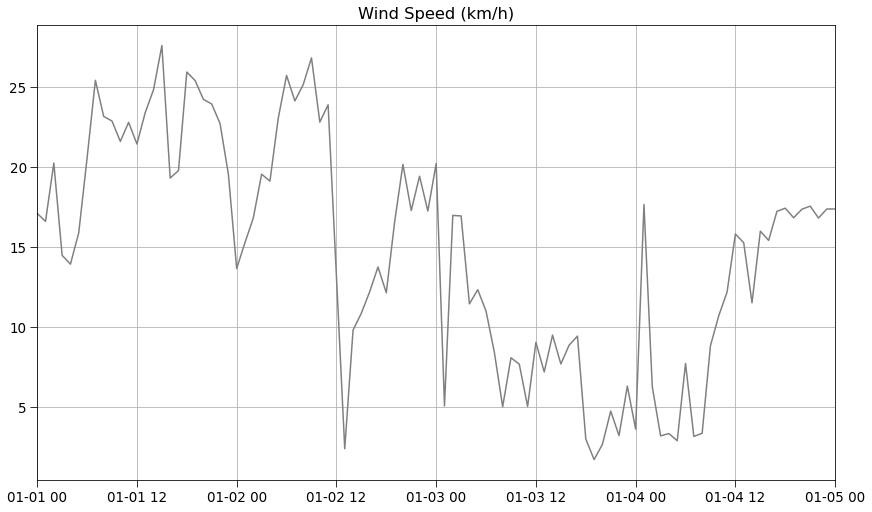

<IPython.core.display.Javascript object>

In [9]:
transformation_train_intv = tss.Interval(ts, train_intv.begin, datetime(2009, 1, 1))
hyper_search_train_intv = tss.Interval(
    ts, transformation_train_intv.end, datetime(2010, 1, 1)
)
hyper_search_val_intv = tss.Interval(ts, hyper_search_train_intv.end, val_intv.begin)
hyper_search_intv = tss.Interval(
    ts, hyper_search_train_intv.begin, hyper_search_val_intv.end
)

fig = plot_ts(
    transformation_train_intv.view(ts), color="grey", name="transformation train"
)
plot_ts(
    hyper_search_train_intv.view(),
    color="tab:green",
    fig=fig,
    name="hyper search train",
)
plot_ts(
    hyper_search_val_intv.view(), color="tab:blue", fig=fig, name="hyper search val"
)
plot_ts(val_intv.view(ts), color="tab:orange", fig=fig, name="val")
display(fig)
display(plot_ts(ts[: datetime(2006, 1, 5)], color="grey"))

In [10]:
normalized_diff_after_ihs_trans = IHSTransformer(
    transformation_train_intv.view(ts), difference_first=False, verbose=True
)
normalized_diff_after_ihs_ts = normalized_diff_after_ihs_trans.transform(ts)
time.sleep(1)
print(
    f"skewness of normalized differenced IHS-transformed time series on transformation train inteval: "
    f"{transformation_train_intv.view(normalized_diff_after_ihs_ts).skew():.5f}"
)
print(
    f"skewness of normalized differenced IHS-transformed time series on hyper-search val inteval: "
    f"{hyper_search_val_intv.view(normalized_diff_after_ihs_ts).skew():.5f}"
)

MLE of IHS lambda: 1.868750e-01
Order of differencing: 1


skewness of normalized differenced IHS-transformed time series on transformation train inteval: 0.09287
skewness of normalized differenced IHS-transformed time series on hyper-search val inteval: 0.03802


<IPython.core.display.Javascript object>

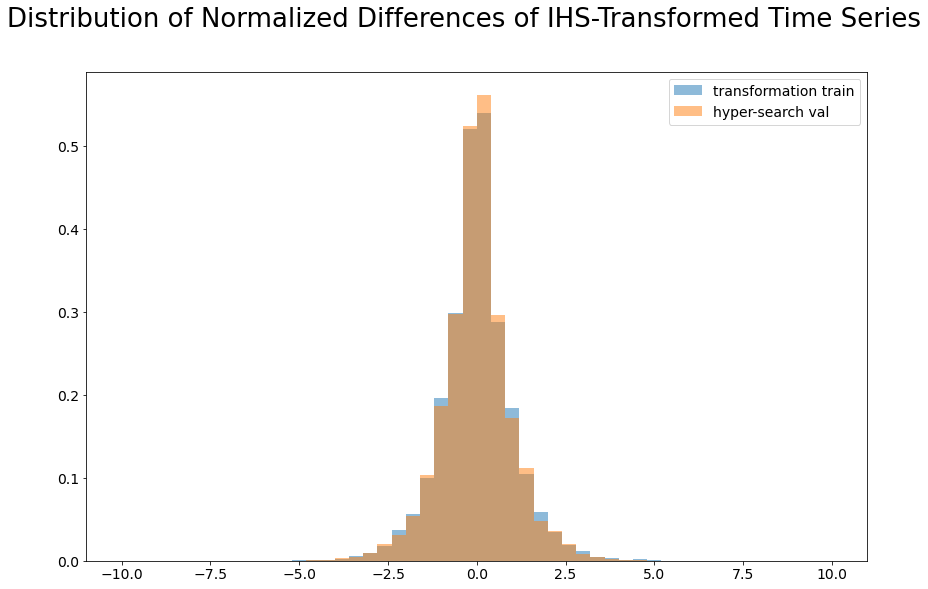

<IPython.core.display.Javascript object>

In [12]:
fig = plot_hist(
    transformation_train_intv.view(normalized_diff_after_ihs_ts),
    bins=50,
    range=(-10, 10),
    density=True,
    name="transformation train",
    title="Distribution of Normalized Differences of IHS-Transformed Time Series",
)
display(
    plot_hist(
        hyper_search_val_intv.view(normalized_diff_after_ihs_ts),
        bins=50,
        range=(-10, 10),
        density=True,
        name="hyper-search val",
        fig=fig,
    )
)

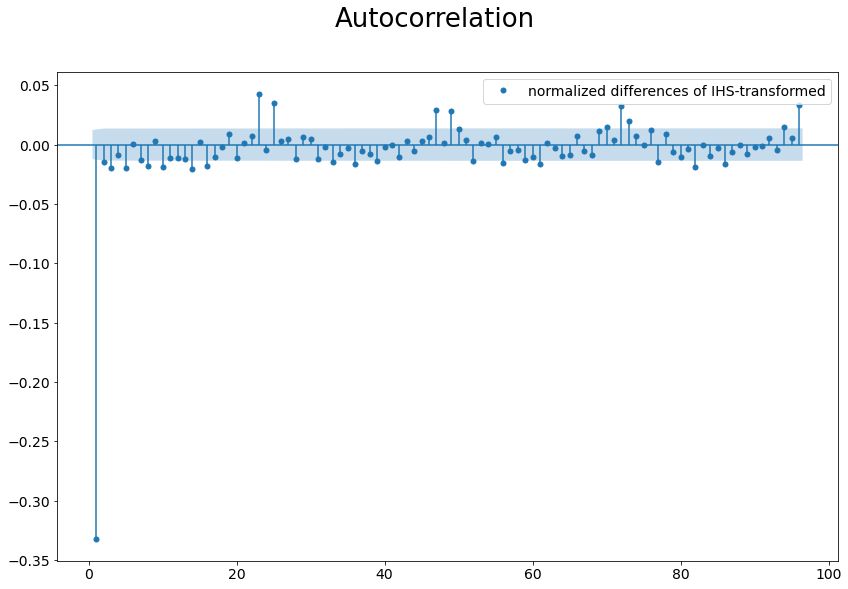

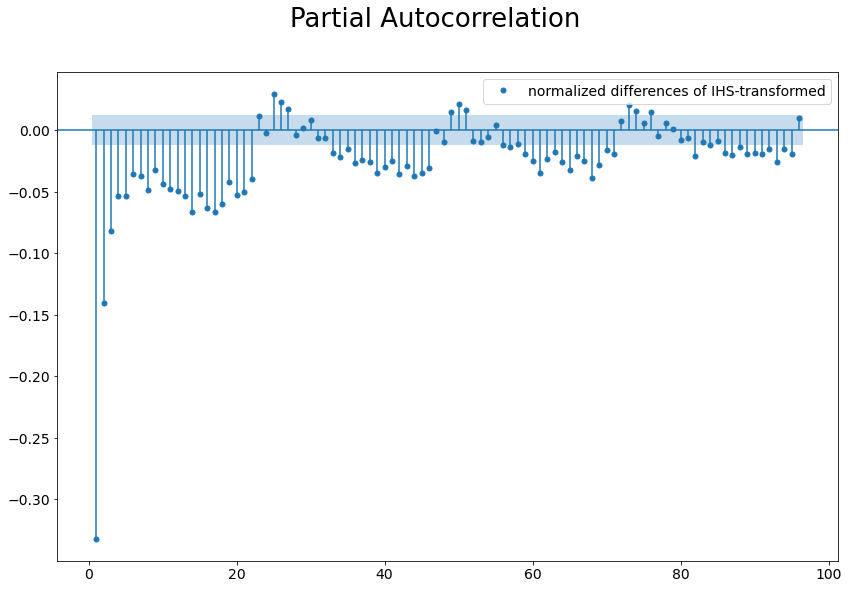

<IPython.core.display.Javascript object>

In [13]:
alpha = 0.05
nlags = 24 * 4
fig = plot_acf(
    transformation_train_intv.view(normalized_diff_after_ihs_ts),
    alpha=alpha,
    nlags=nlags,
    zero=False,
    label="normalized differences of IHS-transformed",
)
display(fig)

alpha = 0.05
pacf_method = "ldbiased"
fig = plot_pacf(
    transformation_train_intv.view(normalized_diff_after_ihs_ts),
    alpha=alpha,
    nlags=nlags,
    zero=False,
    method=pacf_method,
    label="normalized differences of IHS-transformed",
)
display(fig)

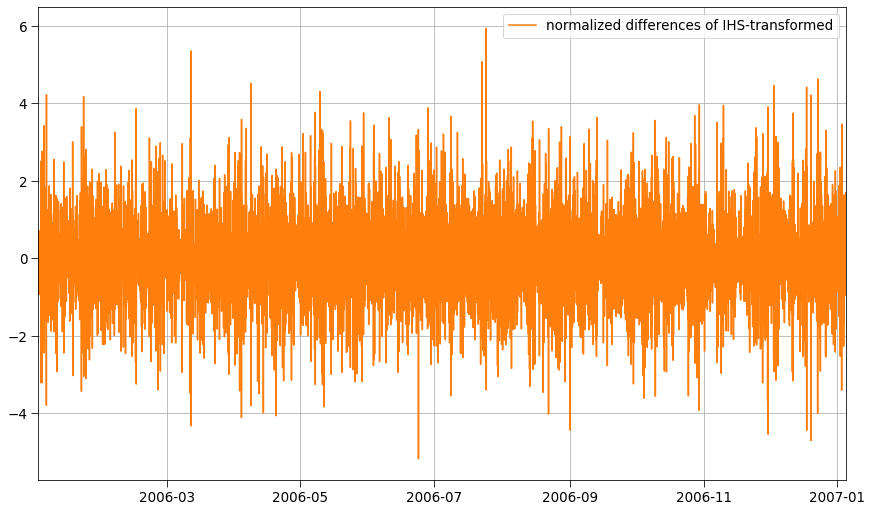

<IPython.core.display.Javascript object>

In [14]:
fig = plot_ts(
    tss.Interval(
        normalized_diff_after_ihs_ts, datetime(2006, 1, 1, 2), datetime(2007, 1, 5)
    ).view(),
    color="tab:orange",
    name="normalized differences of IHS-transformed",
)
display(fig)

## Hyper Parameters Search

In [15]:
trans = normalized_diff_after_ihs_trans
trans_ts = normalized_diff_after_ihs_ts

<IPython.core.display.Javascript object>

In [16]:
intv = tss.Interval(ts, datetime(2006, 1, 1, 2), datetime(2006, 1, 3))

<IPython.core.display.Javascript object>

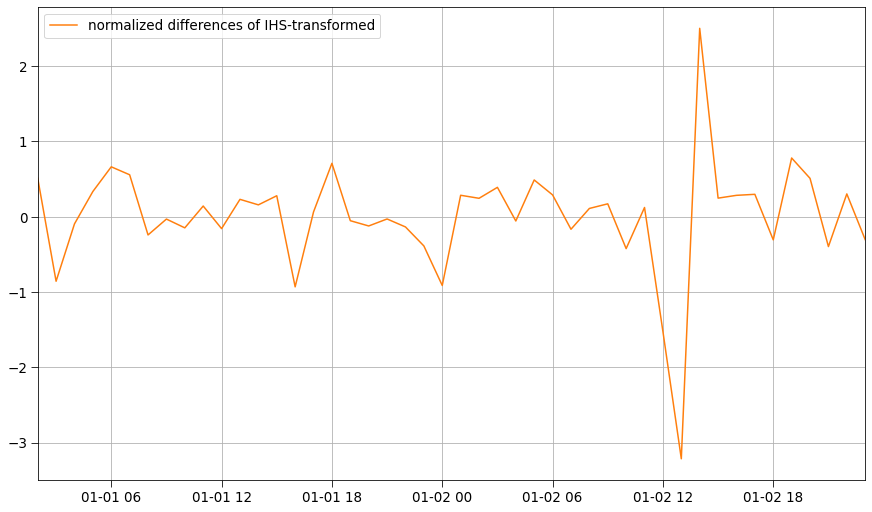

<IPython.core.display.Javascript object>

In [19]:
fig = plot_ts(
    intv.view(trans_ts),
    color="tab:orange",
    name="normalized differences of IHS-transformed",
)
display(fig)

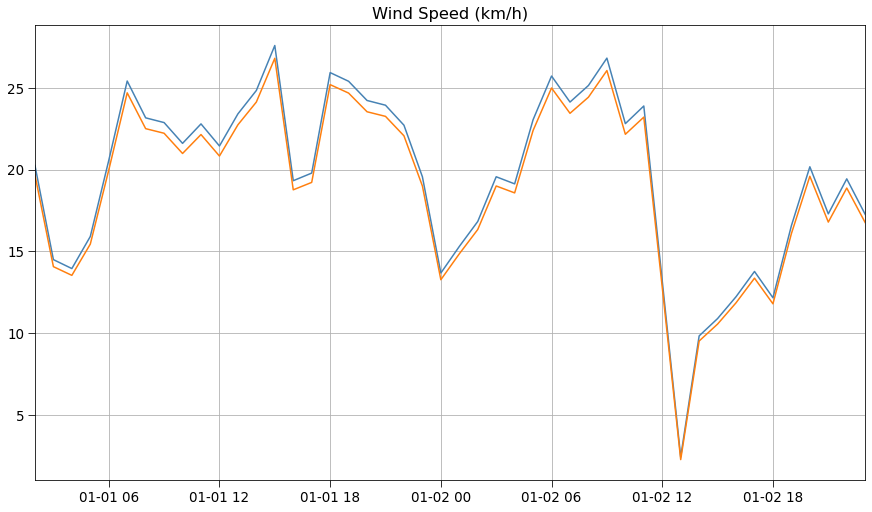

<IPython.core.display.Javascript object>

In [20]:
fig = plot_ts(
    intv.view(ts),
)
plot_ts(
    intv.view(trans.detransform(trans_ts, intv.prev_view())),
    color="tab:orange",
    fig=fig,
)
display(fig)

In [21]:
alpha = 0.05
trans_ts_acf, _ = acf(transformation_train_intv.view(trans_ts), nlags=48, alpha=alpha)
(trans_ts_acf_idx,) = np.where(np.abs(trans_ts_acf) >= 0.05)

trans_ts_pacf, _ = pacf(transformation_train_intv.view(trans_ts), nlags=48, alpha=alpha)
(trans_ts_pacf_idx,) = np.where(np.abs(trans_ts_pacf) >= 0.05)

print(f"acf: {trans_ts_acf_idx}")
print(f"pacf: {trans_ts_pacf_idx}")

acf: [0 1]
pacf: [ 0  1  2  3  4  5 13 14 15 16 17 18 20]


<IPython.core.display.Javascript object>

P ≥ 1 if the ACF is positive at lag s, else P=0.

Q ≥ 1 if the ACF is negative at lag s, else Q=0.

Rule of thumb: P + Q ≤ 2

In [22]:
trans_ts_acf[24]

-0.004355374614070906

<IPython.core.display.Javascript object>

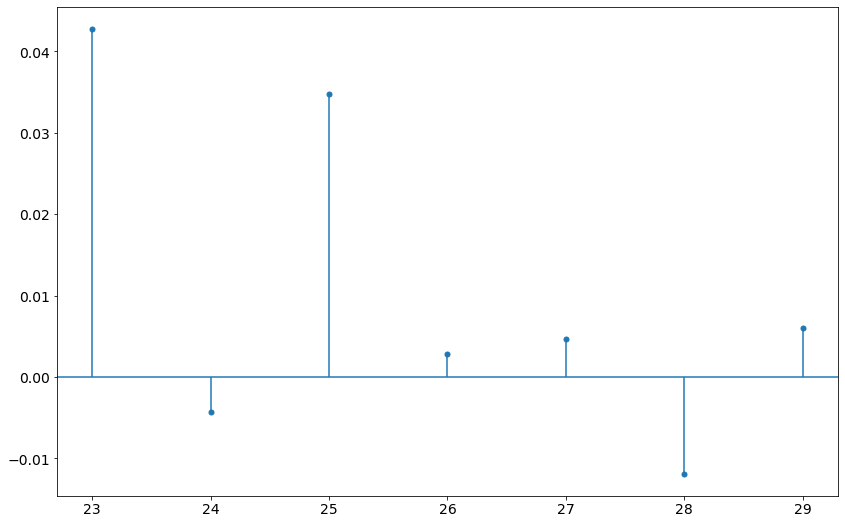

<IPython.core.display.Javascript object>

In [23]:
plot_stats(trans_ts_acf[23:30], xs=np.arange(23, 30))

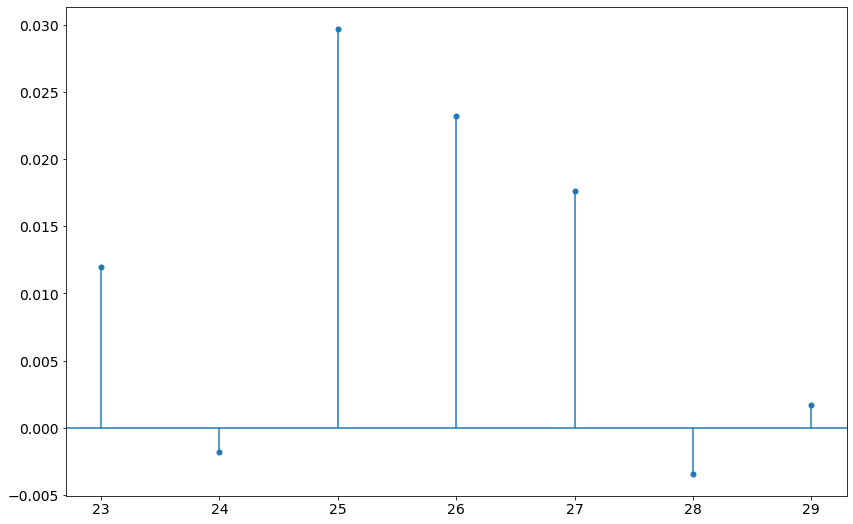

<IPython.core.display.Javascript object>

In [24]:
plot_stats(trans_ts_pacf[23:30], xs=np.arange(23, 30))

In [25]:
def sarima_grid_search(scores=None):
    return grid_search_hyper_params(
        SarimaModel,
        grid,
        trans_ts,
        hyper_search_train_intv,
        hyper_search_val_intv,
        model_params=model_params,
        score_params=score_params,
        fit_params=fit_params,
        best=None,
        scores=scores,
    )

<IPython.core.display.Javascript object>

In [26]:
score_params = dict(
    scorings=["mae"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=125,
    mute=True,
)

fit_params = dict(scoring="mae")

<IPython.core.display.Javascript object>

In [27]:
%%time
p_range = trans_ts_pacf_idx
d_range = [0]
q_range = trans_ts_acf_idx
D_range = [0, 1]
P_range = [0, 1]
Q_range = [0, 1, 2]
grid = make_grid(p=p_range, d=d_range, q=q_range, P=P_range, D=D_range, Q=Q_range)
grid = [v for v in grid if v["p"] + v["d"] + v["q"] + v["P"] + v["D"] + v["Q"] <= 8]

model_params = dict(s=24, max_ts_len=24 * 50, retrain_ts_len=24 * 30)

sarima_grid_search_scores = []
sarima_grid_search_scores1 = sarima_grid_search(sarima_grid_search_scores)

138/138 (21h 9min 48s), the best of all: 4.593 (p=3, d=0, q=1, P=0, D=1, Q=1)                                 


CPU times: user 2d 18min 43s, sys: 1d 2h 27s, total: 3d 2h 19min 10s
Wall time: 21h 9min 49s


<IPython.core.display.Javascript object>

In [41]:
version_suffix = " on normalized differences of IHS-transformed"

<IPython.core.display.Javascript object>

In [18]:
print_hyper_scores(
    sarima_grid_search_scores1[:30],
    sarima_model_version_str,
    s=24,
    suffix=version_suffix,
)

1.   4.593 – SARIMA(3,0,1)(0,1,1)[24] on normalized differences of IHS-transformed
2.   4.596 – SARIMA(3,0,1)(0,1,2)[24] on normalized differences of IHS-transformed
3.   4.608 – SARIMA(2,0,1)(0,1,1)[24] on normalized differences of IHS-transformed
4.   4.632 – SARIMA(4,0,1)(0,1,2)[24] on normalized differences of IHS-transformed
5.   4.642 – SARIMA(5,0,1)(0,1,1)[24] on normalized differences of IHS-transformed
6.   4.645 – SARIMA(5,0,1)(1,0,1)[24] on normalized differences of IHS-transformed
7.   4.656 – SARIMA(3,0,1)(1,0,2)[24] on normalized differences of IHS-transformed
8.   4.658 – SARIMA(2,0,1)(1,1,1)[24] on normalized differences of IHS-transformed
9.   4.663 – SARIMA(3,0,1)(1,1,1)[24] on normalized differences of IHS-transformed
10.  4.669 – SARIMA(4,0,1)(1,0,2)[24] on normalized differences of IHS-transformed
11.  4.689 – SARIMA(4,0,1)(1,0,1)[24] on normalized differences of IHS-transformed
12.  4.693 – SARIMA(2,0,1)(0,1,2)[24] on normalized differences of IHS-transformed
13. 

<IPython.core.display.Javascript object>

In [30]:
sarima_grid_search_scores1

[(4.593484893187077, {'p': 3, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}),
 (4.596238647800464, {'p': 3, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 2}),
 (4.607656261215003, {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}),
 (4.631542705324169, {'p': 4, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 2}),
 (4.642118535648941, {'p': 5, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}),
 (4.644771580313804, {'p': 5, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}),
 (4.655968119632324, {'p': 3, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 2}),
 (4.658017253831543, {'p': 2, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 1}),
 (4.6625145063066595, {'p': 3, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 1}),
 (4.669311479929741, {'p': 4, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 2}),
 (4.688616236057277, {'p': 4, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}),
 (4.692915871818876, {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 2}),
 (4.706593555202986, {'p': 3, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}),
 (4.718895034715576, {'p': 5, 'd': 0, 'q': 1, 'P': 0, 'D': 0, '

<IPython.core.display.Javascript object>

In [39]:
sarima_grid_search_scores1 = [
    (4.593484893187077, {"p": 3, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 1}),
    (4.596238647800464, {"p": 3, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 2}),
    (4.607656261215003, {"p": 2, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 1}),
    (4.631542705324169, {"p": 4, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 2}),
    (4.642118535648941, {"p": 5, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 1}),
    (4.644771580313804, {"p": 5, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 1}),
    (4.655968119632324, {"p": 3, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 2}),
    (4.658017253831543, {"p": 2, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 1}),
    (4.6625145063066595, {"p": 3, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 1}),
    (4.669311479929741, {"p": 4, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 2}),
    (4.688616236057277, {"p": 4, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 1}),
    (4.692915871818876, {"p": 2, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 2}),
    (4.706593555202986, {"p": 3, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 1}),
    (4.718895034715576, {"p": 5, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 2}),
    (4.722410127772227, {"p": 4, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 2}),
    (4.73239092006048, {"p": 2, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 2}),
    (4.732794680736933, {"p": 3, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 2}),
    (4.738063107686214, {"p": 5, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 0}),
    (4.738848409233983, {"p": 2, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 2}),
    (4.7494654174857045, {"p": 3, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 1}),
    (4.751843210250972, {"p": 4, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 0}),
    (4.753220255951164, {"p": 4, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 1}),
    (4.755248176689238, {"p": 5, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 1}),
    (4.755732978272361, {"p": 3, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 0}),
    (4.75779863142317, {"p": 2, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 2}),
    (4.766167682732701, {"p": 2, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 1}),
    (4.770226316496072, {"p": 1, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 2}),
    (4.773979300037284, {"p": 2, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 0}),
    (4.778104605940114, {"p": 4, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 0}),
    (4.77879629732951, {"p": 2, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 1}),
    (4.779507309253294, {"p": 5, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 0}),
    (4.784893772102477, {"p": 3, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 0}),
    (4.80212778177811, {"p": 2, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 0}),
    (4.834329753984702, {"p": 3, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 2}),
    (4.8599038839222946, {"p": 1, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 2}),
    (4.870000366285751, {"p": 1, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 1}),
    (4.870119471221388, {"p": 1, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 1}),
    (4.878417126531866, {"p": 1, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 1}),
    (4.878517470981373, {"p": 4, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 1}),
    (4.961872905786518, {"p": 1, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 2}),
    (5.031915144015512, {"p": 5, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 2}),
    (5.037707841565781, {"p": 5, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 1}),
    (5.039729005548975, {"p": 0, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 1}),
    (5.0410173954612505, {"p": 4, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 2}),
    (5.05779926413764, {"p": 0, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 2}),
    (5.063798197438375, {"p": 5, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 0}),
    (5.064438727977625, {"p": 4, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 1}),
    (5.0931756792532035, {"p": 4, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 0}),
    (5.101227399292323, {"p": 3, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 0}),
    (5.111603389756582, {"p": 3, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 2}),
    (5.114019128216204, {"p": 3, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 1}),
    (5.125945945155586, {"p": 4, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 1}),
    (5.143455951664488, {"p": 2, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 2}),
    (5.160950157626386, {"p": 0, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 1}),
    (5.183906987851785, {"p": 0, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 1}),
    (5.211142215892094, {"p": 1, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 2}),
    (5.212321473398408, {"p": 2, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 1}),
    (5.2183817579082845, {"p": 0, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 2}),
    (5.235303103931267, {"p": 1, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 1}),
    (5.280753712267033, {"p": 0, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 2}),
    (5.317763152068979, {"p": 5, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 1}),
    (5.337908511679714, {"p": 4, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 2}),
    (5.343930908017748, {"p": 3, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 2}),
    (5.366138190646323, {"p": 5, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 2}),
    (5.368850057127417, {"p": 0, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 1}),
    (5.369913135713762, {"p": 3, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 1}),
    (5.377171116302224, {"p": 1, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 2}),
    (5.3886015607298825, {"p": 4, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 2}),
    (5.392917381688752, {"p": 5, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 2}),
    (5.419211936745645, {"p": 1, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 0}),
    (5.421887363696893, {"p": 0, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 2}),
    (5.4266532520975135, {"p": 3, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 2}),
    (5.428970111356522, {"p": 1, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 1}),
    (5.429944169028117, {"p": 5, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 1}),
    (5.437949406169225, {"p": 2, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 2}),
    (5.439348648344565, {"p": 5, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 1}),
    (5.442250814692965, {"p": 5, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 0}),
    (5.443330901735633, {"p": 4, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 2}),
    (5.452783125341443, {"p": 5, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 0}),
    (5.453926188494175, {"p": 4, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 1}),
    (5.458101717014844, {"p": 0, "d": 0, "q": 1, "P": 1, "D": 0, "Q": 0}),
    (5.459306838467461, {"p": 3, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 2}),
    (5.465149618543932, {"p": 1, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 0}),
    (5.4740994817179285, {"p": 0, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 2}),
    (5.479487050119881, {"p": 0, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 0}),
    (5.484204577302033, {"p": 4, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 1}),
    (5.485484570459177, {"p": 2, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 2}),
    (5.48903305071723, {"p": 4, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 0}),
    (5.49430660146844, {"p": 0, "d": 0, "q": 1, "P": 0, "D": 0, "Q": 1}),
    (5.496188526822152, {"p": 4, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 0}),
    (5.505339468989824, {"p": 3, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 1}),
    (5.5066196179738585, {"p": 3, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 0}),
    (5.51400354761927, {"p": 3, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 0}),
    (5.521158990815463, {"p": 2, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 0}),
    (5.5232543489750965, {"p": 2, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 1}),
    (5.529067545837194, {"p": 2, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 1}),
    (5.531439750499817, {"p": 2, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 0}),
    (5.533490948319382, {"p": 4, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 1}),
    (5.543027865881629, {"p": 1, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 2}),
    (5.558738056248164, {"p": 0, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 0}),
    (5.561298935181963, {"p": 0, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 1}),
    (5.5648096014092925, {"p": 0, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 2}),
    (5.565614259889669, {"p": 1, "d": 0, "q": 0, "P": 1, "D": 0, "Q": 0}),
    (5.566111887116178, {"p": 1, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 1}),
    (5.576842687698559, {"p": 1, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 0}),
    (5.581272079173424, {"p": 0, "d": 0, "q": 0, "P": 0, "D": 0, "Q": 0}),
    (5.6395891643694664, {"p": 1, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 2}),
    (5.640727093101279, {"p": 3, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 0}),
    (5.651935627459286, {"p": 4, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 0}),
    (5.662287562969229, {"p": 5, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 0}),
    (5.685294567102221, {"p": 1, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 2}),
    (5.6925701116711585, {"p": 2, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 1}),
    (5.710591227046127, {"p": 3, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 1}),
    (5.732603992080492, {"p": 2, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 2}),
    (5.824089125934599, {"p": 0, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 1}),
    (5.868218379336077, {"p": 1, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 1}),
    (5.943878649899578, {"p": 1, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 1}),
    (6.151036200678488, {"p": 2, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 0}),
    (6.4309114150514946, {"p": 1, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 0}),
    (6.486995138223378, {"p": 5, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 0}),
    (6.519661943146308, {"p": 4, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 0}),
    (6.580563388497683, {"p": 3, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 0}),
    (6.627025939753731, {"p": 0, "d": 0, "q": 1, "P": 1, "D": 1, "Q": 0}),
    (6.628375776934604, {"p": 2, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 0}),
    (6.700952037562497, {"p": 0, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 2}),
    (6.758738802529586, {"p": 1, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 0}),
    (6.9067955379434345, {"p": 0, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 1}),
    (7.011228912583832, {"p": 0, "d": 0, "q": 0, "P": 1, "D": 1, "Q": 0}),
    (7.064798472264766, {"p": 0, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 2}),
    (8.770056342135328, {"p": 2, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 0}),
    (9.175169737988611, {"p": 1, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 0}),
    (9.273927868459754, {"p": 5, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 0}),
    (9.325958543730422, {"p": 4, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 0}),
    (9.400923512097886, {"p": 3, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 0}),
    (9.448455194998878, {"p": 0, "d": 0, "q": 1, "P": 0, "D": 1, "Q": 0}),
    (9.47122782503684, {"p": 2, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 0}),
    (9.70700771504544, {"p": 1, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 0}),
    (10.3245125369574, {"p": 0, "d": 0, "q": 0, "P": 0, "D": 1, "Q": 0}),
]

<IPython.core.display.Javascript object>

In [42]:
chosen_versions = [sarima_grid_search_scores1[i] for i in [0, 1, 5, 7, 9]]
print_hyper_scores(
    chosen_versions, sarima_model_version_str, s=24, suffix=version_suffix
)

1.   4.593 – SARIMA(3,0,1)(0,1,1)[24] on normalized differences of IHS-transformed
2.   4.596 – SARIMA(3,0,1)(0,1,2)[24] on normalized differences of IHS-transformed
3.   4.645 – SARIMA(5,0,1)(1,0,1)[24] on normalized differences of IHS-transformed
4.   4.658 – SARIMA(2,0,1)(1,1,1)[24] on normalized differences of IHS-transformed
5.   4.669 – SARIMA(4,0,1)(1,0,2)[24] on normalized differences of IHS-transformed


<IPython.core.display.Javascript object>

## Training and Validation

In [43]:
models_vals = {
    sarima_model_version_str(val, s=24, suffix=version_suffix): dict(val, s=24)
    for (_, val) in chosen_versions
}
models_full_name_versions = list(models_vals.keys())
models_versions = [
    sarima_model_version(val, suffix=version_suffix)[1]
    for (_, val) in models_vals.items()
]
models = {
    version: SarimaModel(**val, max_ts_len=24 * 50, retrain_ts_len=24 * 30)
    for version, val in models_vals.items()
}

val_mean_scores = {}
val_all_scores = {}
val_preds = {}


def train_and_val_model(model_idx):
    full_model_name = models_full_name_versions[model_idx]
    model_version = models_versions[model_idx]
    print(f"{model_idx+1}. {full_model_name}:", file=sys.stderr)
    model = models[full_model_name]
    model.fit(
        trans_ts,
        tss.Interval(ts, train_intv.end - timedelta(days=50), train_intv.end),
        scoring="mae",
    )
    (
        val_mean_scores[full_model_name],
        val_all_scores[full_model_name],
        val_preds[full_model_name],
    ) = average_scores(
        model,
        trans_ts,
        val_intv,
        scorings=scorings,
        trans=trans,
        original_ts=ts,
        n_steps=pred_steps,
        n_steps_jump=pred_jump,
        return_all_scores=True,
        return_preds=True,
    )
    model_name, _ = sarima_model_version(models_vals[full_model_name])
    val_results.set_model(model_name, model_version)
    val_results.add_model_scores(val_all_scores[full_model_name])
    val_results.add_model_preds(val_preds[full_model_name])
    print(f"results saved", file=sys.stderr)
    time.sleep(0.5)

<IPython.core.display.Javascript object>

In [34]:
%%time
train_and_val_model(0)

1. SARIMA(3,0,1)(0,1,1)[24] on normalized differences of IHS-transformed:
1694/1694 – RMSE: 5.613, MAE: 4.700, MASE: 1.837, sMAPE: 49.350, elapsed time: 3h 3min 49s (last: 16.8s)       results saved


CPU times: user 6h 27min 58s, sys: 4h 17min 54s, total: 10h 45min 52s
Wall time: 3h 4min 42s


<IPython.core.display.Javascript object>

In [35]:
%%time
train_and_val_model(1)

2. SARIMA(3,0,1)(0,1,2)[24] on normalized differences of IHS-transformed:
1694/1694 – RMSE: 5.625, MAE: 4.705, MASE: 1.842, sMAPE: 49.378, elapsed time: 4h 1min 53s (last: 7.7s)        results saved


CPU times: user 10h 43min 54s, sys: 4h 30min 3s, total: 15h 13min 58s
Wall time: 4h 3min 23s


<IPython.core.display.Javascript object>

In [24]:
%%time
train_and_val_model(2)

3. SARIMA(5,0,1)(1,0,1)[24] on normalized differences of IHS-transformed:
1694/1694 – RMSE: 5.645, MAE: 4.700, MASE: 1.829, sMAPE: 49.336, elapsed time: 1h 35min 14s (last: 2.6s)       results saved


CPU times: user 3h 28min 32s, sys: 2h 26min 25s, total: 5h 54min 58s
Wall time: 1h 35min 47s


<IPython.core.display.Javascript object>

In [44]:
%%time
train_and_val_model(3)

4. SARIMA(2,0,1)(1,1,1)[24] on normalized differences of IHS-transformed:
1694/1694 – RMSE: 5.989, MAE: 5.030, MASE: 1.971, sMAPE: 52.639, elapsed time: 2h 3min 18s (last: 5.1s)       results saved


CPU times: user 4h 16min 36s, sys: 2h 38min 30s, total: 6h 55min 6s
Wall time: 2h 4min 51s


<IPython.core.display.Javascript object>

In [23]:
%%time
train_and_val_model(4)

5. SARIMA(4,0,1)(1,0,2)[24] on normalized differences of IHS-transformed:
1694/1694 – RMSE: 5.633, MAE: 4.702, MASE: 1.833, sMAPE: 49.221, elapsed time: 8h 16min 28s (last: 20.8s)      results saved


CPU times: user 16h 47min 4s, sys: 11h 2min 3s, total: 1d 3h 49min 8s
Wall time: 8h 18min 32s


<IPython.core.display.Javascript object>

### Scores

In [8]:
models_names_and_versions = [
    ("SARIMA", "(3,0,1)(0,1,1)[24] on normalized differences of IHS-transformed"),
    ("SARIMA", "(3,0,1)(0,1,2)[24] on normalized differences of IHS-transformed"),
    ("SARIMA", "(5,0,1)(1,0,1)[24] on normalized differences of IHS-transformed"),
    ("SARIMA", "(2,0,1)(1,1,1)[24] on normalized differences of IHS-transformed"),
    ("SARIMA", "(4,0,1)(1,0,2)[24] on normalized differences of IHS-transformed"),
]
val_preds = {}
val_scores = {}
val_mean_scores = {}
for model, version in models_names_and_versions:
    val_results.set_model(model, version)
    val_results.load_model_preds()
    val_results.load_model_scores()
    val_preds[(model, version)] = val_results.get_model_preds()
    val_scores[(model, version)] = val_results.get_model_scores()
    val_mean_scores[(model, version)] = val_results.calc_mean_scores(
        val_scores[(model, version)]
    )

<IPython.core.display.Javascript object>

In [54]:
mae_results = sorted(
    [
        (scores["MAE"], f"{model} {version}")
        for (model, version), scores in val_mean_scores.items()
    ]
)
for i, (score, model_version) in enumerate(mae_results):
    print(f"{i+1}.    {score:.4f} – {model_version}")

1.    4.7001 – SARIMA (3,0,1)(0,1,1)[24] on normalized differences of IHS-transformed
2.    4.7003 – SARIMA (5,0,1)(1,0,1)[24] on normalized differences of IHS-transformed
3.    4.7024 – SARIMA (4,0,1)(1,0,2)[24] on normalized differences of IHS-transformed
4.    4.7050 – SARIMA (3,0,1)(0,1,2)[24] on normalized differences of IHS-transformed
5.    5.0298 – SARIMA (2,0,1)(1,1,1)[24] on normalized differences of IHS-transformed


<IPython.core.display.Javascript object>

### Distributions of Validation Errors

In [12]:
scoring_name = "MAE"
data_fig_name = f"{data_type}: {data_name}"
kwargs = dict(
    title=f"{data_fig_name} – Validation Distribution of {scoring_name}",
    engine="plotly",
)
go_kwargs = dict(xbins=dict(start=0, end=15.0, size=1), histnorm="percent")
legend_layout = dict(
    yanchor="top",
    y=-0.1,
    xanchor="left",
    x=0,
)
layout_kwargs = dict(legend=legend_layout)
fig = None
for ((model, version), scores), color in zip(
    val_scores.items(), mcolors.TABLEAU_COLORS
):
    fig = plot_hist(
        scores[scoring_name],
        name=f"{model} {version}",
        color=color,
        fig=fig,
        go_kwargs=go_kwargs,
        layout_kwargs=layout_kwargs,
        **kwargs,
    )
    kwargs = {}
display(fig)

<IPython.core.display.Javascript object>

### Visualization of Validation Predictions

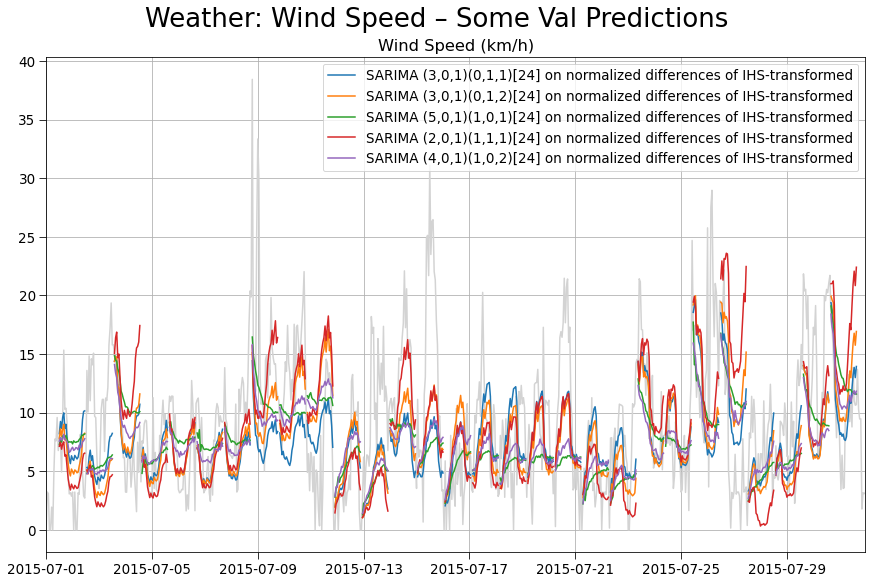

<IPython.core.display.Javascript object>

In [49]:
fig_time_delta = timedelta(hours=0)
short_val_intv = tss.Interval(ts, datetime(2015, 7, 1), datetime(2015, 8, 1))
fig = plot_ground_truth(
    short_val_intv,
    mode="val",
    data_type=data_type,
    data_name=data_name,
    color="lightgrey",
)
for ((model, version), preds), color in zip(val_preds.items(), mcolors.TABLEAU_COLORS):
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        preds,
        model_name=model,
        model_version=version,
        fig=fig,
        color=color,
    )
display(fig)

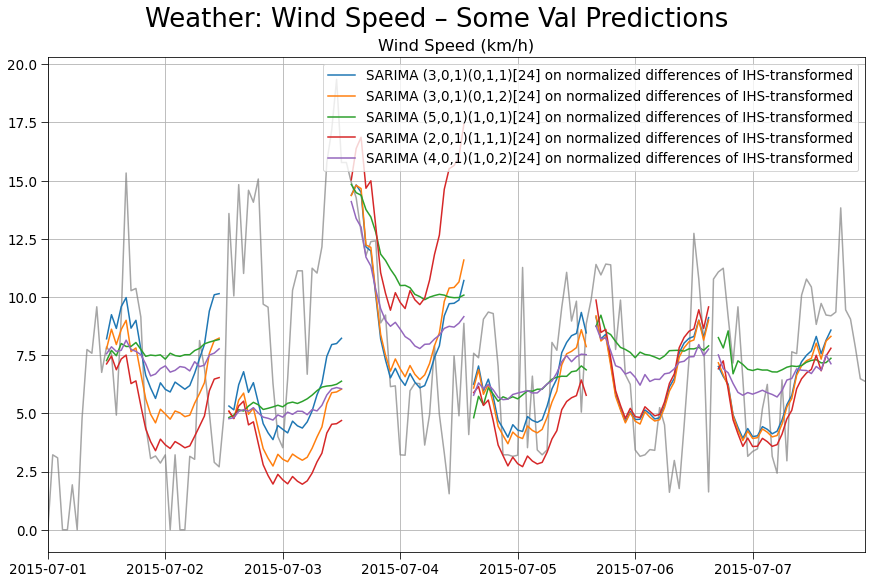

<IPython.core.display.Javascript object>

In [9]:
fig_time_delta = timedelta(hours=0)
short_val_intv = tss.Interval(ts, datetime(2015, 7, 1), datetime(2015, 7, 8))
fig = plot_ground_truth(
    short_val_intv,
    mode="val",
    data_type=data_type,
    data_name=data_name,
    color="grey",
    alpha=0.7,
)
for ((model, version), preds), color in zip(val_preds.items(), mcolors.TABLEAU_COLORS):
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        preds,
        model_name=model,
        model_version=version,
        fig=fig,
        color=color,
    )
display(fig)